# SEGMENTER DES CLIENTS D'UN SITE DE E-COMMERCE

## Contexte

Olist souhaite que vous fournissiez à ses équipes d'e-commerce une segmentation des clients qu’elles pourront utiliser au quotidien pour leurs campagnes de communication.

Votre objectif est de comprendre les différents types d’utilisateurs grâce à leur comportement et à leurs données personnelles.

Vous devrez fournir à l’équipe marketing une description actionable de votre segmentation et de sa logique sous-jacente pour une utilisation optimale, ainsi qu’une proposition de contrat de maintenance basée sur une analyse de la stabilité des segments au cours du temps.

## Données

Pour cette mission, Olist vous fournit une base de données anonymisée comportant des informations sur l’historique de commandes, les produits achetés, les commentaires de satisfaction, et la localisation des clients depuis janvier 2017.

## Mission

Votre mission est d’aider les équipes d’Olist à comprendre les différents types d'utilisateurs. Vous utiliserez donc des méthodes non supervisées pour regrouper des clients de profils similaires. Ces catégories pourront être utilisées par l’équipe Marketing pour mieux communiquer.

## 1. Import des différentes librairies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from IPython import display

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from sklearn.metrics.cluster import adjusted_rand_score

sns.set()
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## 2. Création du dataframe pour les simulations

In [2]:
def fichier_initial(date_param = "2017-08-01"):
    
    '''Création du dataframe contenant uniquement les 4 variables du k-means sur les commandes
    avec une condition sur la date de création de dataframe

    Parametres
    ----------
    date_param : Condition sur la date'''
    
    
    # Ouverture des jeux de données d'intérêt
    customers = pd.read_csv("olist_customers_dataset.csv")
    orders = pd.read_csv("olist_orders_dataset.csv")
    order_items = pd.read_csv("olist_order_items_dataset.csv")
    order_payments = pd.read_csv("olist_order_payments_dataset.csv")
    order_reviews = pd.read_csv("olist_order_reviews_dataset.csv")
    
    # Merge des datasets avec élimination des variables inutiles
    
    # Les commandes
    orders = orders.drop(["order_approved_at", "order_delivered_carrier_date"], axis=1)
    
    order_items = order_items.drop(["seller_id", "shipping_limit_date", "price", "product_id" ,"freight_value"], axis=1)
    
    order_items = pd.merge(orders, order_items, on='order_id', how = 'left')
    
    
    order_payments = order_payments.drop(["payment_type", "payment_sequential", "payment_installments"], axis=1)
    order_payments = pd.merge(order_items, order_payments, on= 'order_id', how='left')
    
    order_reviews = order_reviews.drop(["review_comment_title", "review_comment_message", "review_creation_date", "review_answer_timestamp"], axis=1)
    
    commandes = pd.merge(order_payments, order_reviews, on= 'order_id', how='left')
    
    # Les clients
    customers = customers.drop(["customer_zip_code_prefix", "customer_city", "customer_state"], axis=1)
    
    commandes_customer = pd.merge(commandes, customers, on='customer_id', how='left')
    
    # Conversion des dates
    date_columns = ["order_purchase_timestamp", "order_delivered_customer_date"]
    for col in date_columns:
        commandes_customer[col] = pd.to_datetime(commandes_customer[col], format= "%Y-%m-%d %H:%M:%S")
        
    # Elimination des commandes annulées ou indisponibles
    order_inexploitable = commandes_customer[(commandes_customer['order_status']=='canceled') | (commandes_customer['order_status']=='unavailable')]
    liste_order_inexploitable = order_inexploitable.index.tolist()
    commandes_customer = commandes_customer[~commandes_customer.index.isin(liste_order_inexploitable)]
    
    # Elimination des produits Nan
    produits_mysteres = commandes_customer[commandes_customer["order_item_id"].isna()]
    liste_produits_mysteres = produits_mysteres.index.tolist()
    commandes_customer = commandes_customer[~commandes_customer.index.isin(liste_produits_mysteres)]
    
    # Elimination de la commande aberrante
    commande_suspecte = commandes_customer[commandes_customer["payment_value"] == 13664.08]
    index_commande_suspecte = commande_suspecte.index.tolist()
    commandes_customer = commandes_customer[~commandes_customer.index.isin(index_commande_suspecte)]
        
    # Imputation des valeurs manquantes pour le score
    score_manquant = commandes_customer[commandes_customer["review_score"].isna()]
    liste_score_manquant = score_manquant.index.tolist()
    for idx in liste_score_manquant:
        commandes_customer.loc[idx, "review_score"] = 4
        
    # Feature engineering: Création de la variable recence
    commandes_customer["recence"] = (commandes_customer["order_purchase_timestamp"].max() - commandes_customer["order_purchase_timestamp"]).dt.round('1d').dt.days
    
    commandes_customer = commandes_customer.loc[commandes_customer["order_purchase_timestamp"] <= date_param ,:]
    commandes_customer = commandes_customer.drop("order_purchase_timestamp", axis=1)
    
    # Regroupement des commandes par client sur les 12 derniers mois
    
    df_initial = commandes_customer.groupby("customer_unique_id").agg({"recence": "min","order_id": "nunique", "payment_value":"sum", "review_score": "mean"})
    df_initial = df_initial.rename(columns={"recence":"recence", "order_id": "frequence", "payment_value": "montant", "review_score":"score_moyen"})  
    
    return df_initial

In [3]:
df_initial = fichier_initial()
df_initial.head()

,recence,frequence,montant,score_moyen
customer_unique_id,,,,
0000f46a3911fa3c0805444483337064,542,1,86.22,3.0
0005e1862207bf6ccc02e4228effd9a0,547,1,150.12,4.0
0006fdc98a402fceb4eb0ee528f6a8d4,412,1,29.00,3.0
0010a452c6d13139e50b57f19f52e04e,419,1,325.93,1.0
00115fc7123b5310cf6d3a3aa932699e,589,1,76.11,4.0


In [4]:
print(f'Le fichier clients initial comprend {df_initial.shape[0]} clients.')

Le fichier clients initial comprend 18093 clients.


## 3. Génération de la fonction permettant la réalisation des simulations

In [5]:
def simulation(date_debut, nb_jour=15, max_days_simu=365):

    scaler = StandardScaler()
    ari_score=[]

    date_t0 = date_debut    
    fichier_t0 = fichier_initial(date_param = date_t0)
    fichier_t0_scaled = pd.DataFrame(scaler.fit_transform(fichier_t0),columns = fichier_t0.columns, index=fichier_t0.index)

    model_t0 = KMeans(n_clusters=4, init='k-means++', random_state=42)
    labels_t0 = model_t0.fit_predict(fichier_t0_scaled)

    fichier_t0_scaled['cluster'] = labels_t0

    for i in range(0,max_days_simu,nb_jour):
        date_t1 = date_t0 + timedelta(days=i) 

        fichier_t1 = fichier_initial(date_param = date_t1)
        fichier_t1 = fichier_t1.loc[fichier_t1.index.isin(fichier_t0.index)]
        fichier_t1_scaled = pd.DataFrame(scaler.transform(fichier_t1),columns = fichier_t1.columns, index=fichier_t1.index)

        # model_m1 = KMeans(n_clusters=4, n_init='k-means++',random_state=42)
        labels_t1 = model_t0.predict(fichier_t1_scaled)

        ari_i = adjusted_rand_score(labels_t0, labels_t1)
        
        ari_score.append({'Jours':i,'ARI':ari_i})
    
    return ari_score

## 4. Les simulations

### 4.1. Simulation tous les 15 jours sur une période de 12 mois à compter du 1er aout 2017

In [6]:
# Simulations de 365 jours (12 mois) à compter du 1er aout 2017

date_simu_start_1 = datetime.strptime('01/08/2017', '%d/%m/%Y')

df_resultats_1 = pd.DataFrame(columns=["Jours","ARI","date_simu"])

for i in range(0,12,1): # 12 simulations à 1 mois d'intervalle
    date_simu_1 = date_simu_start_1 + relativedelta(months=i) #timedelta(days=i)
    print(f"{date_simu_1} simulation en cours... ")

    resultats_simu_1 = pd.DataFrame(simulation(date_debut=date_simu_1, nb_jour=15, max_days_simu=365))
    resultats_simu_1["date_simu"] = date_simu_1 
    
    df_resultats_1 = pd.concat([df_resultats_1, resultats_simu_1])    

2017-08-01 00:00:00 simulation en cours... 
2017-09-01 00:00:00 simulation en cours... 
2017-10-01 00:00:00 simulation en cours... 
2017-11-01 00:00:00 simulation en cours... 
2017-12-01 00:00:00 simulation en cours... 
2018-01-01 00:00:00 simulation en cours... 
2018-02-01 00:00:00 simulation en cours... 
2018-03-01 00:00:00 simulation en cours... 
2018-04-01 00:00:00 simulation en cours... 
2018-05-01 00:00:00 simulation en cours... 
2018-06-01 00:00:00 simulation en cours... 
2018-07-01 00:00:00 simulation en cours... 


In [7]:
resultats_plot_1= df_resultats_1.groupby('Jours')[["ARI"]].mean().reset_index()
resultats_plot_1

,Jours,ARI
0,0,1.000000
1,15,0.997497
2,30,0.995286
3,45,0.993242
4,60,0.991470
5,75,0.989752
6,90,0.988178
7,105,0.986666
8,120,0.985199
9,135,0.983904


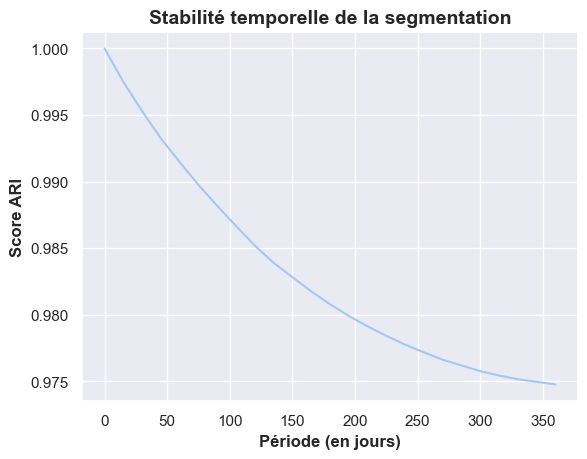

In [8]:
plt.figure()
with sns.color_palette(palette='pastel'):
    plt.rcParams.update({"font.size":10})
    sns.lineplot(data=resultats_plot_1, x="Jours", y="ARI")
    plt.xlabel("Période (en jours)", fontname = 'sans-serif', fontsize= 12, fontweight="bold")
    plt.ylabel("Score ARI", fontname = 'sans-serif', fontsize= 12, fontweight="bold")
    plt.title("Stabilité temporelle de la segmentation", fontname = 'sans-serif', fontsize= 14, fontweight="bold")
plt.show()

**Nous sommes en présence d'une chose assez surprenante. Au bout de 360 jours, le score ARI ne chute que de 3%, rendant le modèle est extrêment stable dans le temps. De ce fait, nous allons réitérer l'analyse sur une période de 19 mois...** 

### 4.2. Simulation tous les 15 jours sur une période de 19 mois à compter du 1er janvier 2017

In [9]:
# Simulations de 19 mois à compter du 1er janvier 2017

date_simu_start_2 = datetime.strptime('01/01/2017', '%d/%m/%Y')

df_resultats_2 = pd.DataFrame(columns=["Jours","ARI","date_simu"])

for i in range(0,19,1): # 19 simulations à 1 mois d'intervalle
    date_simu_2 = date_simu_start_2 + relativedelta(months=i) 
    print(f"{date_simu_2} simulation en cours... ")

    resultats_simu_2 = pd.DataFrame(simulation(date_debut=date_simu_2, nb_jour=15, max_days_simu=580))
    resultats_simu_2["date_simu"] = date_simu_2
    
    df_resultats_2 = pd.concat([df_resultats_2, resultats_simu_2])    

2017-01-01 00:00:00 simulation en cours... 
2017-02-01 00:00:00 simulation en cours... 
2017-03-01 00:00:00 simulation en cours... 
2017-04-01 00:00:00 simulation en cours... 
2017-05-01 00:00:00 simulation en cours... 
2017-06-01 00:00:00 simulation en cours... 
2017-07-01 00:00:00 simulation en cours... 
2017-08-01 00:00:00 simulation en cours... 
2017-09-01 00:00:00 simulation en cours... 
2017-10-01 00:00:00 simulation en cours... 
2017-11-01 00:00:00 simulation en cours... 
2017-12-01 00:00:00 simulation en cours... 
2018-01-01 00:00:00 simulation en cours... 
2018-02-01 00:00:00 simulation en cours... 
2018-03-01 00:00:00 simulation en cours... 
2018-04-01 00:00:00 simulation en cours... 
2018-05-01 00:00:00 simulation en cours... 
2018-06-01 00:00:00 simulation en cours... 
2018-07-01 00:00:00 simulation en cours... 


In [10]:
resultats_plot_2 = df_resultats_2.groupby('Jours')[["ARI"]].mean().reset_index()
resultats_plot_2

,Jours,ARI
0,0,1.000000
1,15,0.997120
2,30,0.994947
3,45,0.992657
4,60,0.990635
5,75,0.988733
6,90,0.987068
7,105,0.984528
8,120,0.982818
9,135,0.981302


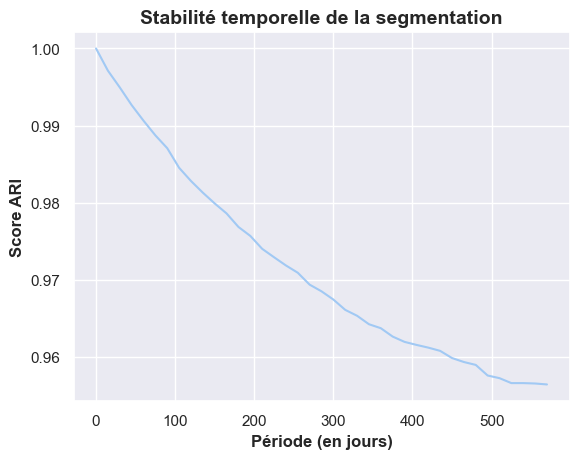

In [11]:
plt.figure()
with sns.color_palette(palette='pastel'):
    plt.rcParams.update({"font.size":10})
    sns.lineplot(data=resultats_plot_2, x="Jours", y="ARI")
    plt.xlabel("Période (en jours)", fontname = 'sans-serif', fontsize= 12, fontweight="bold")
    plt.ylabel("Score ARI", fontname = 'sans-serif', fontsize= 12, fontweight="bold")
    plt.title("Stabilité temporelle de la segmentation", fontname = 'sans-serif', fontsize= 14, fontweight="bold")
plt.show()

**Notre modèle possède toujours un score ARI au-dessus de 0.9 pour une période de 19 mois!!! Une dernière tentative sera donc réalisée sur 21 mois du jeu de données.**

### 4.3. Simulation tous les 15 jours sur une période de 21 mois à compter du 1er janvier 2017

In [12]:
date_simu_start_3 = datetime.strptime('01/11/2016', '%d/%m/%Y')

df_resultats_3 = pd.DataFrame(columns=["Jours","ARI","date_simu"])

for i in range(0,21,1): # 22 simulations à 1 mois d'intervalle
    date_simu_3 = date_simu_start_3 + relativedelta(months=i) 
    print(f"{date_simu_3} simulation en cours... ")

    resultats_simu_3 = pd.DataFrame(simulation(date_debut=date_simu_3, nb_jour=15, max_days_simu=680))
    resultats_simu_3["date_simu"] = date_simu_3
    
    df_resultats_3 = pd.concat([df_resultats_3,resultats_simu_3])    

2016-11-01 00:00:00 simulation en cours... 
2016-12-01 00:00:00 simulation en cours... 
2017-01-01 00:00:00 simulation en cours... 
2017-02-01 00:00:00 simulation en cours... 
2017-03-01 00:00:00 simulation en cours... 
2017-04-01 00:00:00 simulation en cours... 
2017-05-01 00:00:00 simulation en cours... 
2017-06-01 00:00:00 simulation en cours... 
2017-07-01 00:00:00 simulation en cours... 
2017-08-01 00:00:00 simulation en cours... 
2017-09-01 00:00:00 simulation en cours... 
2017-10-01 00:00:00 simulation en cours... 
2017-11-01 00:00:00 simulation en cours... 
2017-12-01 00:00:00 simulation en cours... 
2018-01-01 00:00:00 simulation en cours... 
2018-02-01 00:00:00 simulation en cours... 
2018-03-01 00:00:00 simulation en cours... 
2018-04-01 00:00:00 simulation en cours... 
2018-05-01 00:00:00 simulation en cours... 
2018-06-01 00:00:00 simulation en cours... 
2018-07-01 00:00:00 simulation en cours... 
2018-08-01 00:00:00 simulation en cours... 


In [13]:
resultats_plot_3 = df_resultats_3.groupby('Jours')[["ARI"]].mean().reset_index()
resultats_plot_3

,Jours,ARI
0,0,1.000000
1,15,0.997412
2,30,0.995494
3,45,0.993516
4,60,0.991770
5,75,0.990127
6,90,0.988689
7,105,0.986495
8,120,0.985019
9,135,0.983230


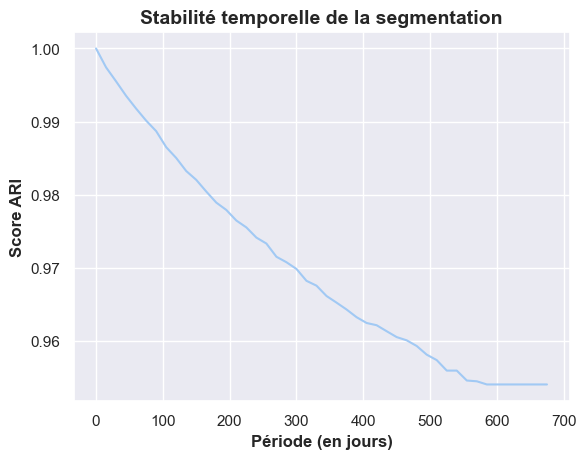

In [14]:
plt.figure()
with sns.color_palette(palette='pastel'):
    plt.rcParams.update({"font.size":10})
    sns.lineplot(data=resultats_plot_3, x="Jours", y="ARI")
    plt.xlabel("Période (en jours)", fontname = 'sans-serif', fontsize= 12, fontweight="bold")
    plt.ylabel("Score ARI", fontname = 'sans-serif', fontsize= 12, fontweight="bold")
    plt.title("Stabilité temporelle de la segmentation", fontname = 'sans-serif', fontsize= 14, fontweight="bold")
plt.show()

**Notre modèle possède toujours un score ARI au-dessus de 0.9 pour une période de 21 mois!!! Comme nous sommes sur la quasi-totalité du jeu de données, nous ne pouvons donc plus réaliser de simulations...**

## CONCLUSION SUR LE CONTRAT DE MAINTENANCE: 

### Segmentation stable sur 21 mois soit la quasi-totalité du jeu de données
- **Le délai de maintenance n'a donc pas pu être strictement établi: il sera donc supérieur à 21 mois...**
- **Hypothèse sur cette stabilité: Seuls 3% des clients ont passé plus d'une commande et parmi mes 4 clusters, 3 comprennent des clients n'ayant effectué qu'un seul achat avec des montants moyens globlalement similaires et le dernier cluster comprend tous les clients ayant effectué plus d'un achat (et certains n'ayant effectué qu'un seul achat) avec les montants les plus élevés?????**